# Importar bibliotecas necesarias

In [3]:
import sys
import os
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import librosa
import librosa.display
import IPython
import keras as k
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import joblib


### Se crea una funcion para modularizar el código guardado en scripts para facilitar su uso

In [4]:
# Ruta base del proyecto
base_dir = Path.cwd().parents[0] 

#Creacion de las variables de path para los scripts
data_path = os.path.join(base_dir,"DNN_Music", 'docs', 'data', 'musicdataset.csv')


# Función para importar y ejecutar scripts
def run_script(script_path):
    """Ejecutar el script especificado"""
    sys.path.append(os.path.dirname(script_path))
    script_name = os.path.basename(script_path).replace('.py', '')
    module = importlib.import_module(script_name)

    # Codigo que llama las funciones modularizadas
    if hasattr(module, 'load_data_set'):
        df, descriptions = module.load_data_set()
        return df, descriptions  
    else:
        return module

# 1. Adquisición de los datos

In [3]:
#Aquí se utiliza la funcion auxiliar definida previamente para obtener la carga del df y del dicccionario de descripciones
df, descriptions = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'data_acquisition', 'data_acquisition.py'))
print(df)

Data set cargado con exito  y diccionario de descripciones creado
               filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0     blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1     blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2     blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3     blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4     blues.00000.4.wav   66149          0.335579         0.088129  0.143289   
...                 ...     ...               ...              ...       ...   
9985   rock.00099.5.wav   66149          0.349126         0.080515  0.050019   
9986   rock.00099.6.wav   66149          0.372564         0.082626  0.057897   
9987   rock.00099.7.wav   66149          0.347481         0.089019  0.052403   
9988   rock.00099.8.wav   66149          0.387527         0.084815  0.066430   
9989   rock.00099.9.wav   66149          0.369293     

### Limpieza inicial de los datos, eliminamos las columnas de 'filename' y 'length', se recibe el modulo de preprocesamiento para poder usar las funciones individuales

In [4]:
#Se utiliza la funcion auxiliar definida previamente para obtener el modulo de preprocesamiento 
prepro_module = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'preprocessing', 'preprocessing.py'))
#Limpieza y obtencion de las particiones
X_train, X_dev, X_test, y_train, y_dev, y_test, df_clean, scaler = prepro_module.clean_df(df)
joblib.dump(scaler, 'scaler.pkl')
print(df_clean)

El conjunto de entrenamiento tiene 6993 registros de un total de 9990, lo cual representa el 70%
El conjunto de validación tiene 1978 registros de un total de 9990, lo cual representa el 20%
El conjunto de prueba tiene 1019 registros de un total de 9990, lo cual representa el 10%
      chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0             0.335406         0.091048  0.130405  0.003521   
1             0.343065         0.086147  0.112699  0.001450   
2             0.346815         0.092243  0.132003  0.004620   
3             0.363639         0.086856  0.132565  0.002448   
4             0.335579         0.088129  0.143289  0.001701   
...                ...              ...       ...       ...   
9985          0.349126         0.080515  0.050019  0.000097   
9986          0.372564         0.082626  0.057897  0.000088   
9987          0.347481         0.089019  0.052403  0.000701   
9988          0.387527         0.084815  0.066430  0.000320   
9989          0.369293    

# 2. Analisis exploratorio de los datos

In [5]:
#Se obtiene el modulo de analisis exploratorio de los datos
eda_module = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'eda', 'eda.py'))

### Dimensiones del Dataframe

In [6]:
#Cuantos registros tiene nuestro DF?
eda_module.df_shape(df_clean)


El dataset que vamos a utilizar tiene las dimensiones (9990, 60).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   chroma_stft_mean         9990 non-null   float64
 1   chroma_stft_var          9990 non-null   float64
 2   rms_mean                 9990 non-null   float64
 3   rms_var                  9990 non-null   float64
 4   spectral_centroid_mean   9990 non-null   float64
 5   spectral_centroid_var    9990 non-null   float64
 6   spectral_bandwidth_mean  9990 non-null   float64
 7   spectral_bandwidth_var   9990 non-null   float64
 8   rolloff_mean             9990 non-null   float64
 9   rolloff_var              9990 non-null   float64
 10  zero_crossing_rate_mean  9990 non-null   float64
 11  zero_crossing_rate_var   9990 non-null   float64
 12  harmony_mean             9990 non-null   float64
 13  harmony_var

### Memoria en uso del df

In [7]:
#Cuanto espacio en memoria consume el DF?
eda_module.memory_usage(df_clean)

Este dataset tiene un tamaño de 5.015237808227539 MB.


### ¿En qué formato están guardados los datos?

In [8]:
eda_module.data_type(df_clean)

Los tipos de datos en el dataframe son:

float64    57
int64       2
object      1
Name: count, dtype: int64.


### Hay datos faltantes en el DataFrame?

In [9]:
eda_module.missing_data(df_clean)

chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var                  0
mfcc9_mean                 0
mfcc9_var     

### Podemos ver que no hay ningún dato faltante en el dataset seleccionado.

## *Visualización de las labels en el df y su distribución en los géneros músicales*

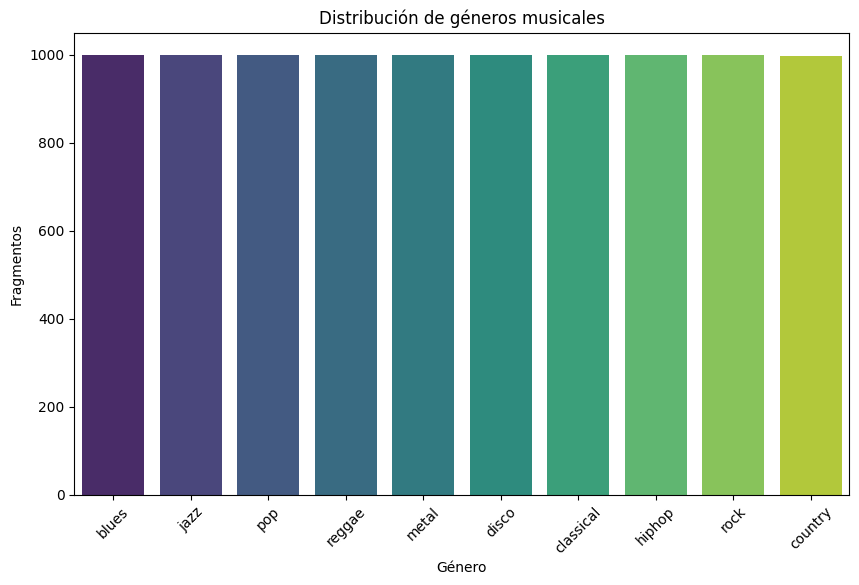

In [10]:
eda_module.label_visualizer(df_clean)

## *Prueba de audios (11 audios por genero)*

In [11]:

#Construimos una funcion que modulariza el cambio de samples de musica dentro de nuestro proyecto
def play_audio(genre="classical", number=0):
    genres = ['classical', 'blues', 'rock', 'pop', 'hiphop', 'disco', 'jazz', 'reggae', 'country', 'metal']
    if genre not in genres:
        print("No es un género válido, por favor seleccione uno de los siguientes géneros:")
        for genero in genres:
            print(genero)
        return
    if number > 10 or number < 0:
        print("El numero de muestra debe estar entre 0 y 11")
        return
    
    number_str = str(number).zfill(2)
    
    # Construir la ruta y el nombre del archivo
    samples_path = os.path.join(base_dir, "DNN_Music", 'docs', 'data','genres_original', genre)
    audio = os.path.join(samples_path, f"{genre}.000{number_str}.wav")
    data, sr = librosa.load(audio)
    return data, sr




## Aqui utilizamos la funcion definida anteriormente para mostrar diferentes samples de musica de los datos usados

In [12]:

sample_data, sr = play_audio(genre="classical", number=10)
IPython.display.Audio(sample_data,rate=sr)

## Vamos a utilizar nuestra primera funcion auxiliar para llamar los modulos de el modelo principal (DNN) y uno alternativo (KNN)

In [13]:
main_training_module = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'training', 'DNN_v2.py'))
alternative_training_module = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'training', 'KNN_v2.py'))
df_KNN, descriptions = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'data_acquisition', 'data_acquisition.py'))
evaluate_module = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'evaluation', 'main.py'))

Data set cargado con exito  y diccionario de descripciones creado


## La siguiente celda modela, entrena y reporta el modelo usando DNN

Creando modelo con forma de X_train: (6993, 57)
Modelo creado exitosamente.


a:\Users\arell\anaconda3\envs\botsDiscord\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        59,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 757,322 (2.89 MB)

 Trainable params: 757,322 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3058 - loss: 1.9253 - val_accuracy: 0.5768 - val_loss: 1.2217
Epoch 2/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5579 - loss: 1.3003 - val_accuracy: 0.6886 - val_loss: 0.9181
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6499 - loss: 1.0671 - val_accuracy: 0.7032 - val_loss: 0.8403
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6984 - loss: 0.9247 - val_accuracy: 0.7412 - val_loss: 0.7484
Epoch 5/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7365 - loss: 0.8070 - val_accuracy: 0.7644 - val_loss: 0.7432
Epoch 6/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7691 - loss: 0.7351 - val_accuracy: 0.7644 - val_loss: 0.6894
Epoch 7/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7970 - loss: 0.6305 - val_accuracy: 0.8170 - val_loss: 0.5450
Epoch 8/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8171 - loss: 0.5818 - val_accuracy: 0.8089 - 

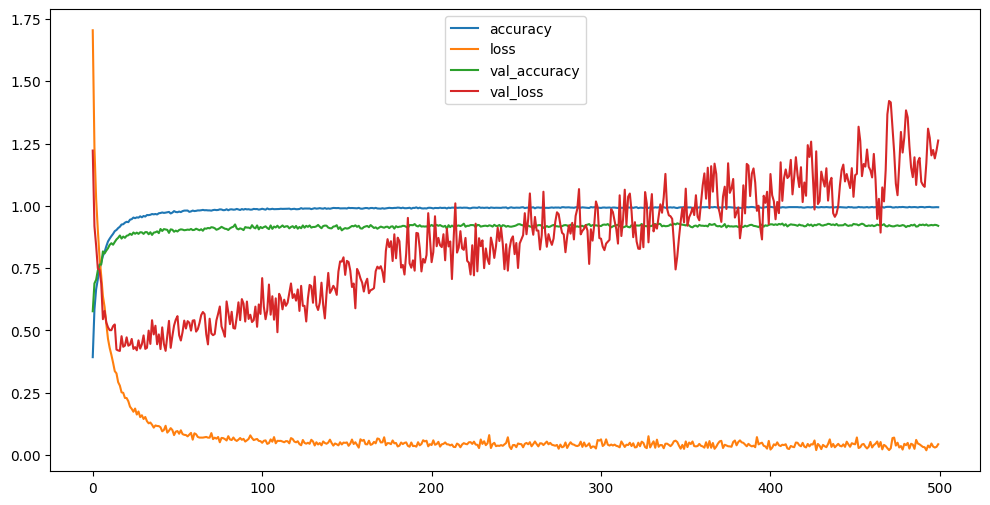

In [14]:
model_history, model = main_training_module.create_model(X_train, y_train, X_dev, y_dev)

main_training_module.plotHistory(model_history)


## Ahora vamos a evaluar el modelo alternativo usando KNN y el df cargado para este proposito

Training set score: 0.955
Test set score: 0.896
Log-loss en el conjunto de prueba: 1.518
Mejor precisión en la prueba: 89.59%


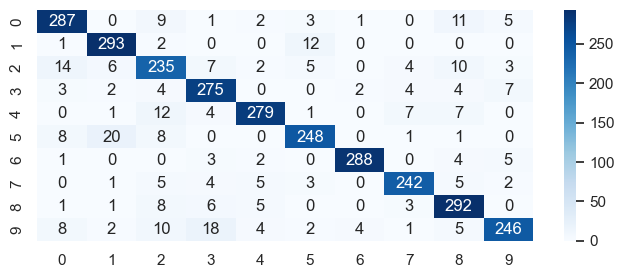

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       319
           1       0.90      0.95      0.92       308
           2       0.80      0.82      0.81       286
           3       0.86      0.91      0.89       301
           4       0.93      0.90      0.91       311
           5       0.91      0.87      0.89       286
           6       0.98      0.95      0.96       303
           7       0.92      0.91      0.91       267
           8       0.86      0.92      0.89       316
           9       0.92      0.82      0.87       300

    accuracy                           0.90      2997
   macro avg       0.90      0.90      0.90      2997
weighted avg       0.90      0.90      0.90      2997



In [15]:
KNN_model, KNN_acc, KNN_loss = alternative_training_module.KNN_model(df_KNN)

In [16]:
DNN_loss, DNN_acc = model.evaluate(X_test, y_test, batch_size=128)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9269 - loss: 1.2628 


In [17]:
evaluate_module.print_comparison(DNN_loss, DNN_acc, KNN_loss, KNN_acc)

Resultados del DNN:
Pérdida en prueba: 1.0824134349822998, Precisión en prueba: 93.42492818832397%

Resultados del KNN:
Pérdida en prueba: 1.5179812298763682, Precisión en prueba: 89.5895895895896%

Comparativa:
El DNN tiene mejor precisión en la prueba.


### Teniendo en cuenta los resultados anteriores DNN (93%) KNN (87.72%), decidimos seguir con el modelo base de DNN como se había planteado en un inicio

In [18]:
# Obtenemos los valores de las etiquetas
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


## Vamos a ver las predicciones con los primeros 15 fragmentos, recordemos que para nuestro dataset, se asignaron 10 etiquetas (0-9) correspondientes a cada uno de los géneros, siendo:

*   0 - Blues
*   1 - Classical
*   2 - Country
*   3 - Disco
*   4 - HipHop
*   5 - Jazz
*   6 - Metal
*   7 - Pop
*   8 - Reggae
*   9 - Rock


In [19]:
# Comparamos los valores reales con los predichos
comparaciones_df = pd.DataFrame({
    'Etiqueta Real': y_test,
    'Etiqueta Predicha': y_pred_labels,
    "Acierto": y_test == y_pred_labels
})

print(comparaciones_df.head(15))

      Etiqueta Real  Etiqueta Predicha  Acierto
7331              8                  8     True
9001              6                  6     True
2640              6                  6     True
583               2                  2     True
3745              2                  2     True
9964              2                  2     True
1435              6                  6     True
364               4                  4     True
106               4                  4     True
8187              1                  1     True
6536              3                  3     True
6135              0                  0     True
8259              1                  1     True
1238              4                  4     True
4520              1                  1     True


Finalmente, en la matriz de confusión podemos visualizar los aciertos y desaciertos en pruebas. Por ejemplo, podemos observar que todos los desaciertos que tuvo el modelo para el genero de Classical los etiquetó como Jazz, pues si bien es un error propio del modelo, también es importante tener en cuenta la similitud que pueda existir entre las caracteristicas de audio de ambos géneros tal y como vimos en los fragmentos anteriores.

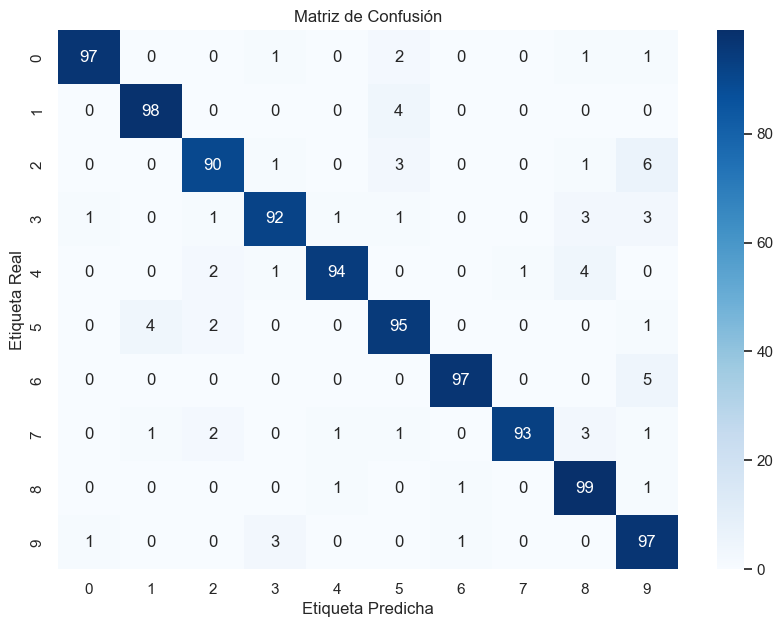

In [20]:
# Matriz de confusión para pruebas
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

In [21]:
model.save("DNN_v1.h5")
print("Modelo guardado como 'DNN_v1.h5'")

Modelo guardado como 'DNN_v1.h5'


## A partir de ahora, el modelo fue guardado y será desplegado utilizando Hugging spaces y gradio como interfaz, el siguiente codigo muestra la aplicación en cuestion, pero no está implementado para ser ejecutado desde este notebook


In [ ]:
import gradio as gr
import numpy as np
import keras as k
from sklearn.preprocessing import StandardScaler as skp
import joblib

# Load the previously saved model and scaler
model = k.models.load_model("DNN_v1.h5")
scaler = joblib.load('scaler.pkl')
genres = {
    "0": "Blues",
    "1": "Classical",
    "2": "Country",
    "3": "Disco",
    "4": "HipHop",
    "5": "Jazz",
    "6": "Metal",
    "7": "Pop",
    "8": "Reggae",
    "9": "Rock"
}


print("Model loaded successfully.")

# Instructions for the user
instructions = """
Please enter the feature values in the following format (comma-separated) this is a valid input entry classified as Blues:

0.335406363, 0.091048293, 0.130405024, 0.003521004, 1773.065032, 167541.6309, 1972.744388, 117335.7716, 3714.560359, 1080789.886, 
0.081850962, 0.000557687, -7.85E-05, 0.00835359, -6.82E-05, 0.005535193, 129.1992188, -118.6279144, 2440.286621, 125.0836258, 260.9569092,
-23.44372368, 364.0817261, 41.32148361, 181.6948547, -5.976108074, 152.9631348, 20.11514091, 75.65229797, -16.04541016, 40.22710419,
17.85519791, 84.32028198, -14.6334343, 83.43723297, 10.27052689, 97.00133514, -9.708278656, 66.66989136, 10.18387508, 45.10361099,
-4.681614399, 34.16949844, 8.417439461, 48.26944351, -7.233476639, 42.7709465, -2.853603363, 39.68714523, -3.241280317, 36.4882431,
0.722208977, 38.09915161, -5.050335407, 33.61807251, -0.243026793, 43.77176666

Ensure that the values are separated by commas and in the correct order as described below:

| Variable               | Description                                                                                           | Data Type | Possible Values               |Estimated Range                              |
|------------------------|-------------------------------------------------------------------------------------------------------|-----------|--------------------------------|----------------------------------------------|
| chroma_stft_mean       | Mean of the chroma short-time Fourier transform, related to the tonality.                             | Numeric   | Real values.                  |  [0.0, 1.0]                                   |
| chroma_stft_var        | Variance of the chroma short-time Fourier transform, measures tonal dispersion.                       | Numeric   | Real values.                  |  [0.0, 0.1]                                   |
| rms_mean               | Mean of the root mean square of the spectrum, reflects the average intensity.                         | Numeric   | Real values.                  |  [0.0, 1.0]                                   |
| rms_var                | Variance of the root mean square, indicates variability in intensity.                                  | Numeric   | Real values.                  |  [0.0, 0.1]                                   |
| spectral_centroid_mean | Mean spectral centroid, indicates the "brightness" of the sound.                                      | Numeric   | Real values.                  |  [0.0, 8000.0]                                |
| spectral_centroid_var  | Variance of spectral centroid, measures brightness variation.                                         | Numeric   | Real values.                  |  [0.0, 1000000.0]                             |
| spectral_bandwidth_mean| Mean spectral bandwidth, measures the width of the frequency range.                                    | Numeric   | Real values.                  |  [0.0, 4000.0]                                |
| spectral_bandwidth_var | Variance of spectral bandwidth, indicates fluctuations in the frequency range.                         | Numeric   | Real values.                  |  [0.0, 1000000.0]                             |
| rolloff_mean           | Mean rolloff frequency, where 85% of the spectral energy is concentrated.                             | Numeric   | Real values.                  |  [0.0, 8000.0]                                |
| rolloff_var            | Variance of rolloff frequency, reflects changes in spectral energy distribution.                       | Numeric   | Real values.                  |  [0.0, 1000000.0]                             |
| zero_crossing_rate_mean| Mean zero-crossing rate, indicates the frequency of sign changes in the signal.                        | Numeric   | Real values.                  |  [0.0, 1.0]                                   |
| zero_crossing_rate_var | Variance of zero-crossing rate, measures variability in sign changes.                                 | Numeric   | Real values.                  |  [0.0, 0.1]                                   |
| harmony_mean           | Mean harmony in the signal, reflects the overall tonality.                                            | Numeric   | Real values.                  |  [0.0, 1.0]                                   |
| harmony_var            | Variance of harmony, measures tonal dispersion.                                                      | Numeric   | Real values.                  | [0.0, 0.1]                                   |
| perceptr_mean          | Mean perceptuality, describes perceptual aspects of the sound.                                        | Numeric   | Real values.                  |  [0.0, 1.0]                                   |
| perceptr_var           | Variance of perceptuality, measures variability in perceptual aspects.                                | Numeric   | Real values.                  |  [0.0, 0.1]                                   |
| tempo                  | Estimated tempo of the signal, in beats per minute (bpm).                                              | Numeric   | Real values (typical: 0-300).  |  [0.0, 300.0]                                 |
| mfccX_mean             | Mean of the Mel-frequency cepstral coefficient in frequency X, related to texture of the sound.       | Numeric   | Real values.                  |  [-50.0, 50.0]                                |
| mfccX_var              | Variance of the Mel-frequency cepstral coefficient in frequency X, measures variability in texture.   | Numeric   | Real values.                  | [0.0, 100.0]                                 |

Take note that mfccX_mean and mfccX_var go from X = 1 up to 20.

Make sure to enter the features in the correct order as shown in the table.
"""

# Function to make predictions
def predict(features):
    try:
        # Split input string by commas and convert to float
        features_array = np.array([float(x) for x in features.split(",")]).reshape(1, -1)
        
        # Check if the number of features matches the expected number
        if len(features_array[0]) != 57:
            return f"Error: You must provide exactly 57 features, but you provided {len(features_array[0])}."
        
        # Apply scaling
        features_array_scaled = scaler.transform(features_array)
        
        # Make prediction
        prediction = model.predict(features_array_scaled)
        
        # Return the class with the highest probability
        predicted_class = np.argmax(prediction, axis=1)[0]

                # Get the genre name using the predicted class
        predicted_genre = genres[str(predicted_class)]
        
        return f"Prediction: {predicted_class} - {predicted_genre}"
    
    except ValueError as ve:
        return f"Error: Invalid input format. Please ensure all values are numbers. {ve}"
    except Exception as e:
        return f"Error: {e}"

# Create the Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(label="Features (comma-separated)"),
    outputs="text",
    title="Music genre classificator with Keras",
    description=instructions
)

# Launch the interface
if __name__ == "__main__":
    interface.launch(share=True)

## Podemos hacer uso de la API de la siguiente manera:

In [1]:
from gradio_client import Client

client = Client("ArellanoBrunoC/DNN_Music")
result = client.predict(
		features="0.335406363, 0.091048293, 0.130405024, 0.003521004, 1773.065032, 167541.6309, 1972.744388, 117335.7716, 3714.560359, 1080789.886, 0.081850962, 0.000557687, -7.85E-05, 0.00835359, -6.82E-05, 0.005535193, 129.1992188, -118.6279144, 2440.286621, 125.0836258, 260.9569092, -23.44372368, 364.0817261, 41.32148361, 181.6948547, -5.976108074, 152.9631348, 20.11514091, 75.65229797, -16.04541016, 40.22710419, 17.85519791, 84.32028198, -14.6334343, 83.43723297, 10.27052689, 97.00133514, -9.708278656, 66.66989136, 10.18387508, 45.10361099, -4.681614399, 34.16949844, 8.417439461, 48.26944351, -7.233476639, 42.7709465, -2.853603363, 39.68714523, -3.241280317, 36.4882431, 0.722208977, 38.09915161, -5.050335407, 33.61807251, -0.243026793, 43.77176666",
		api_name="/predict"
)
print(result)


a:\Users\arell\anaconda3\envs\botsDiscord\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded as API: https://arellanobrunoc-dnn-music.hf.space ✔
Prediction: 0 - Blues


## Como última demostración, vamos a automatizar el proceso de acceso a los datos (dentro del mismo data set) para facilitar el acceso a datos de entrada diferentes de la prueba anterior

In [ ]:
# Recargamos nuestro Dataset
df_to_test, descriptions = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'data_acquisition', 'data_acquisition.py'))
df_to_test = df_to_test.drop(['filename', 'length'], axis=1, errors='ignore')

Data set cargado con exito  y diccionario de descripciones creado


In [ ]:
def APi_Prediction(row_index, dataframe):
    try:
        # Obtener la fila correspondiente
        row = dataframe.iloc[row_index]
        
        # Convertir la fila a una lista de valores en formato string
        row_values = row.astype(str).tolist()
        
        # Unir los valores con comas
        row_string = ",".join(row_values)

        result = client.predict(
		features=f"{row_string}",
		api_name="/predict"
        )
        print(result)

        return result
    
    except IndexError:
        return f"Error: La fila con índice {row_index} no existe en el DataFrame."
    except Exception as e:
        return f"Error: {e}"